In [1]:
!nvidia-smi

Mon May  8 05:21:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
import tensorflow as tf
tf.__version__

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'2.11.0'

In [3]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCH=30

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/plant-village/PlantVillage",

    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [6]:
class_names=dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
len(dataset)

645

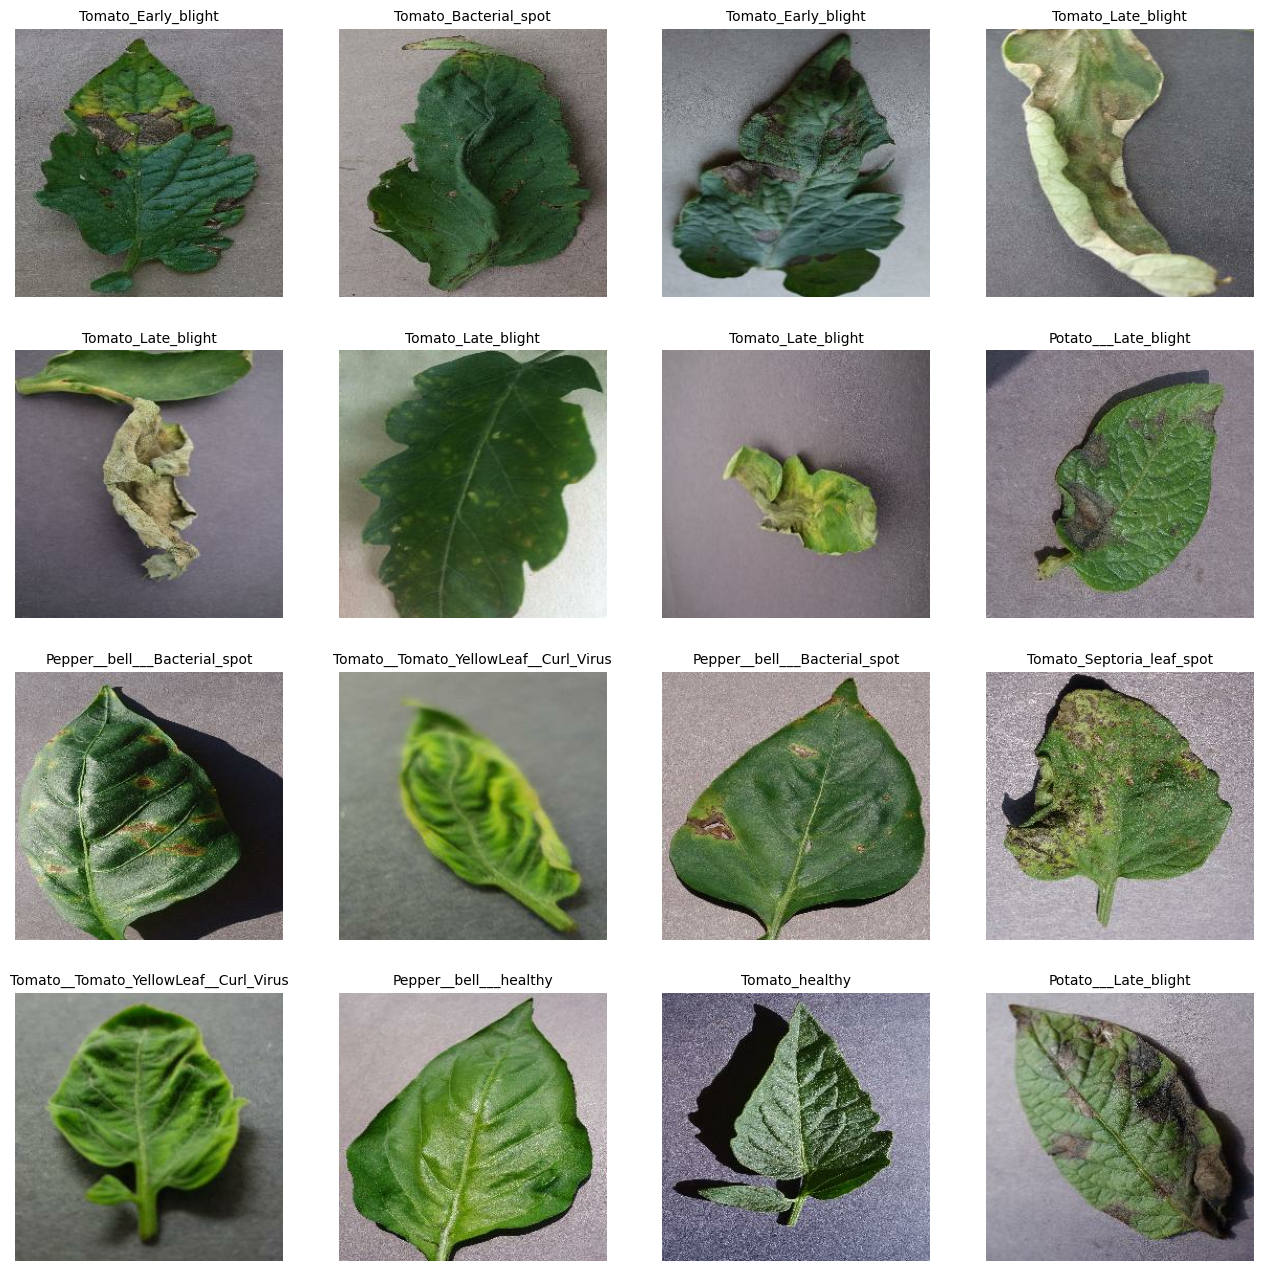

In [8]:
plt.figure(figsize=(16,16))
for image_batch,label_batch in dataset.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]],fontsize=10)
    plt.axis("off")

In [9]:
print(len(dataset))
train_size=0.8
len(dataset)*train_size

645


516.0

In [10]:
train_dataset=dataset.take(511)
len(train_dataset)

511

In [11]:
test_dataset=dataset.skip(511)
len(test_dataset)

134

In [12]:
val_size=0.1
len(dataset)*val_size

64.5

In [13]:
val_dataset=test_dataset.take(64)
len(val_dataset)

64

In [14]:
test_dataset=test_dataset.skip(64)
len(test_dataset)

70

In [15]:
#,shuffle=True,shuffle_size=10000
# if shuffle:
    #ds=ds.shuffle(shuffle_size,seed=12)
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1):
  ds_size=len(dataset)

 
    
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)
  
  train_ds=ds.take(train_size)

  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return  train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

516

In [18]:
len(test_ds)

65

In [19]:
len(val_ds)

64

In [20]:
#train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=15
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [25]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy( from_logits=False),
    metrics=['accuracy']
)

In [26]:
history=model.fit(
    train_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/30
516/516 [==============================] - 127s 211ms/step - loss: 1.8019 - accuracy: 0.4101 - val_loss: 1.7354 - val_accuracy: 0.4302
Epoch 2/30
516/516 [==============================] - 103s 199ms/step - loss: 1.0188 - accuracy: 0.6572 - val_loss: 1.5418 - val_accuracy: 0.5308
Epoch 3/30
516/516 [==============================] - 100s 194ms/step - loss: 0.6918 - accuracy: 0.7634 - val_loss: 1.3584 - val_accuracy: 0.5991
Epoch 4/30
516/516 [==============================] - 99s 192ms/step - loss: 0.5359 - accuracy: 0.8155 - val_loss: 1.1245 - val_accuracy: 0.6753
Epoch 5/30
516/516 [==============================] - 103s 200ms/step - loss: 0.4416 - accuracy: 0.8477 - val_loss: 0.8232 - val_accuracy: 0.7417
Epoch 6/30
516/516 [==============================] - 104s 200ms/step - loss: 0.3911 - accuracy: 0.8656 - val_loss: 1.0830 - val_accuracy: 0.7026
Epoch 7/30
516/516 [==============================] - 104s 200ms/step - loss: 0.3481 - accuracy: 0.8792 - val_loss: 0.5258 - 

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
scores=model.evaluate(test_ds)

65/65 [==============================] - 33s 138ms/step - loss: 0.4148 - accuracy: 0.8821


In [29]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

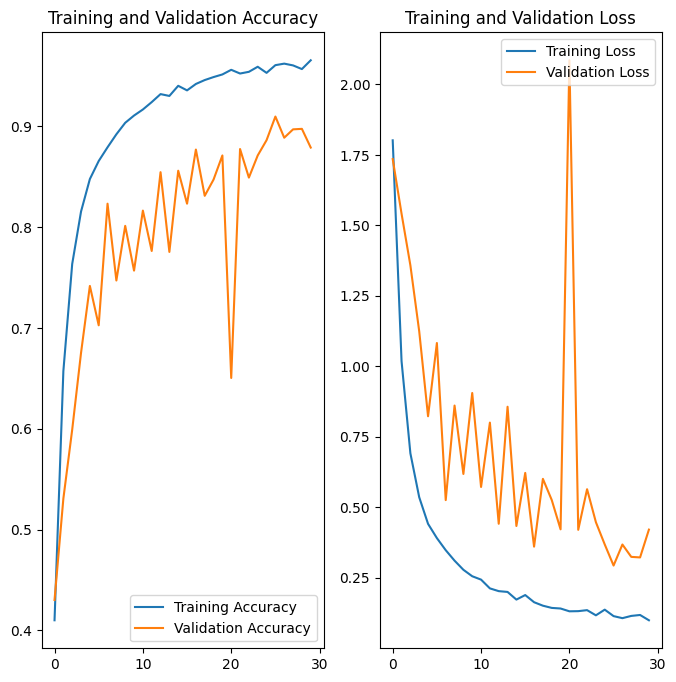

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCH),acc,label='Training Accuracy')
plt.plot(range(EPOCH),val_acc,label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(range(EPOCH),loss,label='Training Loss')
plt.plot(range(EPOCH),val_loss,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

first image to predict
first image's actyal label is: Tomato_healthy
1/1 [==============================] - 0s 181ms/step
predicted label: Tomato_healthy


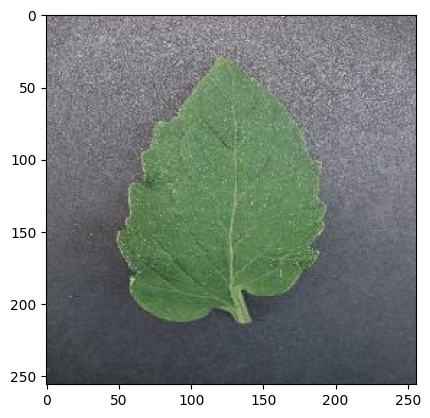

In [31]:
for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actyal label is:", class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)

  predictions=model.predict(img_array)

  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 25ms/step


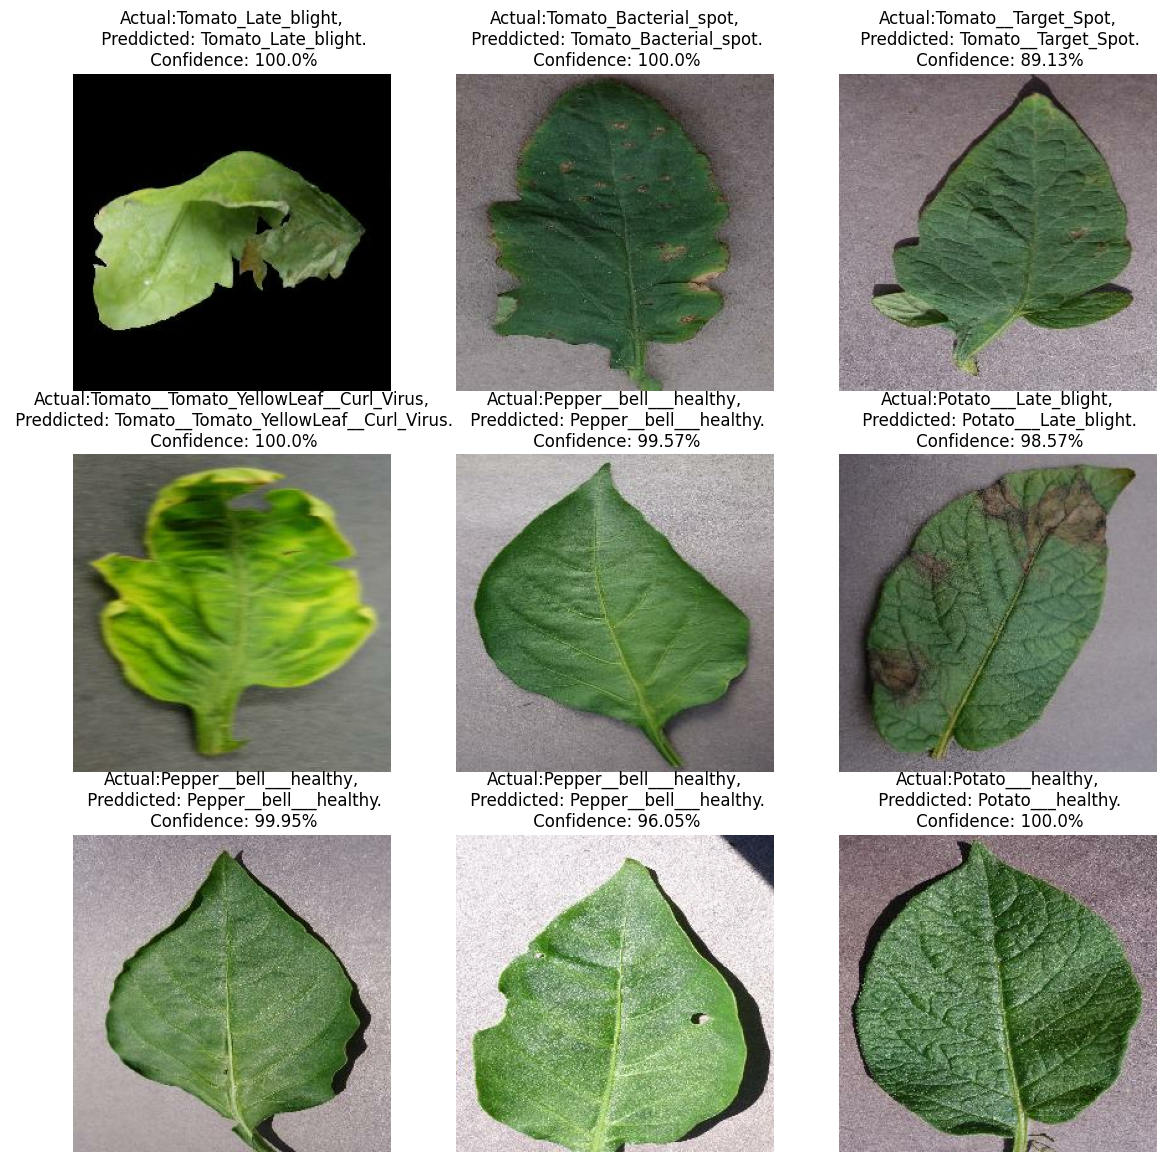

In [33]:
plt.figure(figsize=(14,14))
for images,labels in test_ds.take(1):
  for i in range(9):
    x=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class,confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]

    plt.title(f"Actual:{actual_class},\n Preddicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [35]:
len(test_ds)

65

In [48]:
y_pred=model.predict(test_ds)
y_pred=np.argmax(y_pred,axis=1)
print(y_pred)
labels=[]
for x,y in test_ds.as_numpy_iterator():
  labels.append(y)
y_true=np.concatenate(labels)
print(y_true)

65/65 [==============================] - 39s 59ms/step
[ 8  3 12 ...  9 12 12]
[ 2 13  0 ...  7  9  0]


In [37]:
cm =confusion_matrix(y_true,y_pred)

In [38]:
print(cm)

[[ 6  2  0  3  1 13  4  5  3  9  7  8 17  5  7]
 [ 7 10  6  8  1 15  5  9  7 23  5 12 24  5 13]
 [ 2  6  2  4  1 11 13  6  3  4  5  4 17  2  6]
 [ 2  4 10  9  0  6 11 10  6 11 11  3 18  2 11]
 [ 0  1  1  0  0  2  1  0  0  2  0  0  1  0  2]
 [10 15  8 10  0 24  9 14 13 21 16  8 47  6 16]
 [ 1  4  4  4  1 13  7 10  5 13  4  3 20  3  7]
 [ 9 16  6 10  1 21 19 15  2 19  5 10 36  6 20]
 [ 6 12  3  3  1  8  4  7  7  9 14  6 14  3 13]
 [11 17  1  3  0 17 11  4 12 17 13  5 27  8 20]
 [ 9  9 10  9  0 13 10 14  6 14 13 11 25 11 19]
 [ 6 18  8  6  0  6  8 14  6 16  3  9 25  4  7]
 [ 9 24 13 11  2 32 25 28 16 32 24 15 47 12 32]
 [ 1  3  4  3  0  1  2  2  4  9  3  4  7  3  1]
 [ 7 10 11 10  0 10 12 11  9 13 11 12 30 11  6]]


Text(0.5, 1.0, 'Confusion Matrix')

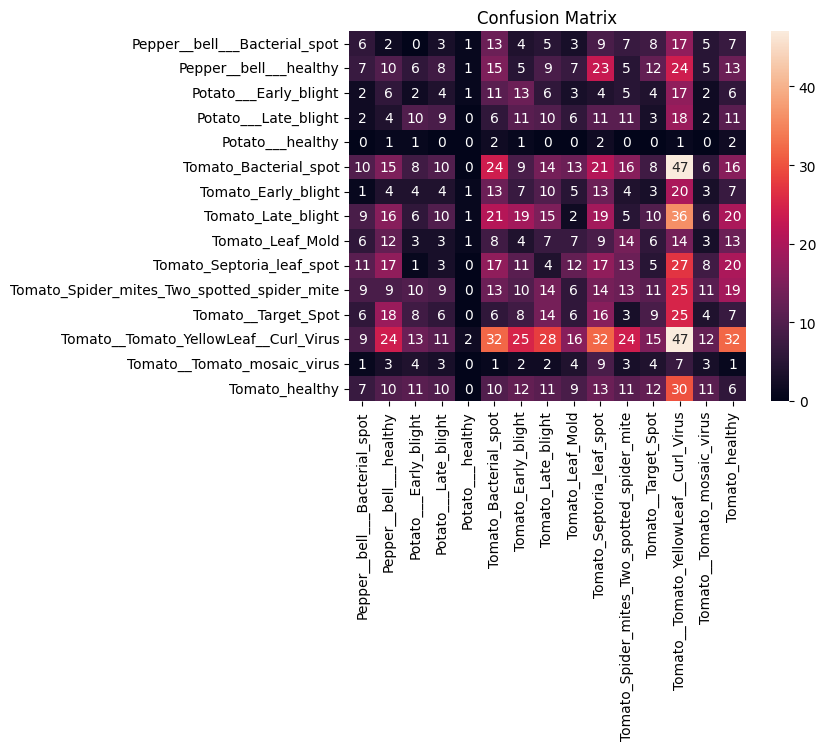

In [39]:
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")

In [40]:
from sklearn.metrics import classification_report
cr=classification_report(y_true,y_pred,target_names=class_names)
print(cr)

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.07      0.07      0.07        90
                     Pepper__bell___healthy       0.07      0.07      0.07       150
                      Potato___Early_blight       0.02      0.02      0.02        86
                       Potato___Late_blight       0.10      0.08      0.09       114
                           Potato___healthy       0.00      0.00      0.00        10
                      Tomato_Bacterial_spot       0.12      0.11      0.12       217
                        Tomato_Early_blight       0.05      0.07      0.06        99
                         Tomato_Late_blight       0.10      0.08      0.09       195
                           Tomato_Leaf_Mold       0.07      0.06      0.07       110
                  Tomato_Septoria_leaf_spot       0.08      0.10      0.09       166
Tomato_Spider_mites_Two_spotted_spider_mite       0.10      0.08

In [45]:
#Saving The model
model.save("/kaggle/working/custom.h5")

In [46]:
from tensorflow import keras
model_d=keras.models.load_model("/kaggle/working/custom.h5")

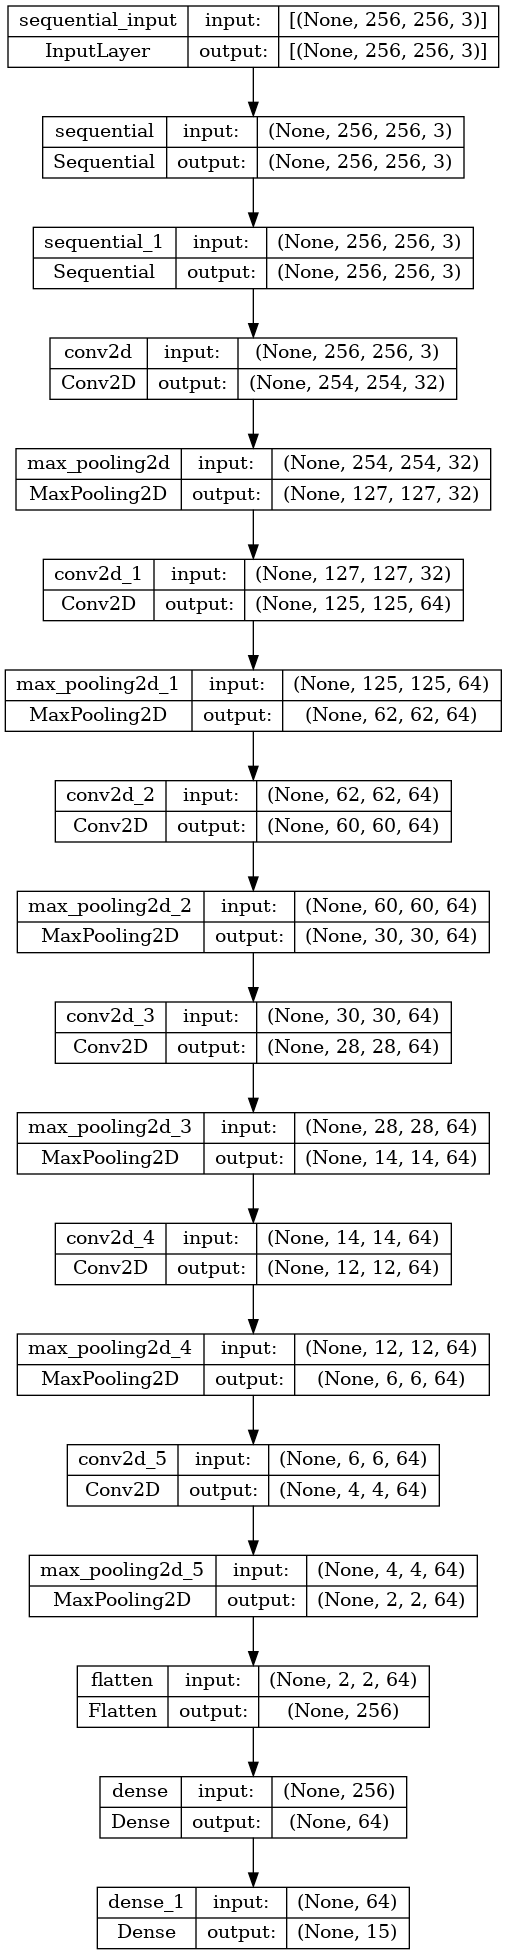

In [47]:
import tensorflow as tf
tf.keras.utils.plot_model(model_d, to_file='/kaggle/working/plot_Custom.png', show_shapes=True, show_layer_names=True)